## Flight Delay Regression Modeling

In [3]:
import os
import psycopg2
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 

In [4]:
data=pd.read_csv('flights.csv', skiprows=lambda i:i%20!=0)

In [5]:
data=data.dropna(axis=0, how='all')

In [6]:
data.shape

(500000, 43)

In [48]:
data['arr_delay'].describe()

count    490573.000000
mean          5.064317
std          48.769159
min         -91.000000
25%         -15.000000
50%          -6.000000
75%           8.000000
max        1779.000000
Name: arr_delay, dtype: float64

In [86]:
# for the target data, the limit is set as (-100, 100) --based on the data exploration result
df=data.copy()

In [87]:
# assign the outlier number to lower limit -100, and upper limit 100
df.loc[df['arr_delay']<-100, 'arr_delay']=-100
df.loc[df['arr_delay']>100, 'arr_delay']=100

In [88]:
df['arr_delay'].describe()

count    490573.000000
mean          1.977353
std          28.830495
min         -91.000000
25%         -15.000000
50%          -6.000000
75%           8.000000
max         100.000000
Name: arr_delay, dtype: float64

In [89]:
cols=['fl_date', 'mkt_unique_carrier','mkt_carrier_fl_num', 'origin_airport_id', 'origin_city_name',
       'dest_airport_id', 'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'arr_delay', 'crs_elapsed_time']

In [90]:
feature_col=['fl_date', 'mkt_unique_carrier','mkt_carrier_fl_num', 'origin_airport_id', 'origin_city_name',
       'dest_airport_id', 'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time']

In [91]:
test=pd.read_csv('test_data')
test.head()

,Unnamed: 0,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,...,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance
0,0,2020-01-01,WN,WN,WN,5888,WN,N951WN,5888,13891,...,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363
1,1,2020-01-01,WN,WN,WN,6276,WN,N467WN,6276,13891,...,"Ontario, CA",14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363
2,2,2020-01-01,WN,WN,WN,4598,WN,N7885A,4598,13891,...,"Ontario, CA",14831,SJC,"San Jose, CA",2020,2130,N,70,1,333
3,3,2020-01-01,WN,WN,WN,4761,WN,N551WN,4761,13891,...,"Ontario, CA",14831,SJC,"San Jose, CA",1340,1455,N,75,1,333
4,4,2020-01-01,WN,WN,WN,5162,WN,N968WN,5162,13891,...,"Ontario, CA",14831,SJC,"San Jose, CA",915,1035,N,80,1,333


In [145]:
test.shape

(660556, 21)

In [92]:
df=df[cols]
dt=test[feature_col]

In [94]:
# extract fly date as year, month, weekday, week
df['fl_date']=pd.to_datetime(df['fl_date'])
df['fl_year']=df['fl_date'].dt.year 
df['fl_month']=df['fl_date'].dt.month 
df['fl_day_of_week']=df['fl_date'].dt.weekday
df['fl_week_of_year']=df['fl_date'].dt.week
df['dep_hour']=(df['crs_dep_time']/100).astype(int)
df['arr_hour']=(df['crs_arr_time']/100).astype(int)

In [95]:
# transforming test _data
dt['fl_date']=pd.to_datetime(dt['fl_date'])
dt['fl_year']=dt['fl_date'].dt.year 
dt['fl_month']=dt['fl_date'].dt.month 
dt['fl_day_of_week']=dt['fl_date'].dt.weekday
dt['fl_week_of_year']=dt['fl_date'].dt.week
dt['dep_hour']=(dt['crs_dep_time']/100).astype(int)
dt['arr_hour']=(dt['crs_arr_time']/100).astype(int)

In [96]:
## read the airport average departure delay time from airport data table
airport=pd.read_csv('airport.csv')

In [97]:
airport.head()

,Unnamed: 0,origin_airport_id,fl_month,fl_day_of_week,dep_delay
0,0,10135,1,0,158.000000
1,1,10135,1,1,67.750000
2,2,10135,1,2,24.333333
3,3,10135,1,3,85.000000
4,4,10135,1,4,72.000000


In [98]:
df.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,origin_city_name,dest_airport_id,dest_city_name,crs_dep_time,crs_arr_time,arr_delay,crs_elapsed_time,fl_year,fl_month,fl_day_of_week,fl_week_of_year,dep_hour,arr_hour
0,2018-03-25,DL,2130,10397,"Atlanta, GA",15304,"Tampa, FL",1630,1800,-16.0,90.0,2018,3,6,12,16,18
1,2018-03-25,DL,2145,14685,"Savannah, GA",10397,"Atlanta, GA",600,710,-14.0,70.0,2018,3,6,12,6,7
2,2018-03-25,DL,2166,13487,"Minneapolis, MN",15096,"Syracuse, NY",2030,2340,-9.0,130.0,2018,3,6,12,20,23
3,2018-03-25,DL,2182,11433,"Detroit, MI",10693,"Nashville, TN",1730,1806,-5.0,96.0,2018,3,6,12,17,18
4,2018-03-25,DL,2199,10397,"Atlanta, GA",11292,"Denver, CO",1259,1422,21.0,203.0,2018,3,6,12,12,14


In [99]:
dt.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,origin_city_name,dest_airport_id,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,fl_year,fl_month,fl_day_of_week,fl_week_of_year,dep_hour,arr_hour
0,2020-01-01,WN,5888,13891,"Ontario, CA",14771,"San Francisco, CA",1810,1945,95,2020,1,2,1,18,19
1,2020-01-01,WN,6276,13891,"Ontario, CA",14771,"San Francisco, CA",1150,1320,90,2020,1,2,1,11,13
2,2020-01-01,WN,4598,13891,"Ontario, CA",14831,"San Jose, CA",2020,2130,70,2020,1,2,1,20,21
3,2020-01-01,WN,4761,13891,"Ontario, CA",14831,"San Jose, CA",1340,1455,75,2020,1,2,1,13,14
4,2020-01-01,WN,5162,13891,"Ontario, CA",14831,"San Jose, CA",915,1035,80,2020,1,2,1,9,10


In [100]:
# training data and test data merge with the ariport delay data 
DF=pd.merge(df,airport,how='left', on=['origin_airport_id','fl_month','fl_day_of_week'])
dt1=pd.merge(dt,airport,how='left', on=['origin_airport_id','fl_month','fl_day_of_week'])

In [101]:
DF.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,origin_city_name,dest_airport_id,dest_city_name,crs_dep_time,crs_arr_time,arr_delay,crs_elapsed_time,fl_year,fl_month,fl_day_of_week,fl_week_of_year,dep_hour,arr_hour,Unnamed: 0,dep_delay
0,2018-03-25,DL,2130,10397,"Atlanta, GA",15304,"Tampa, FL",1630,1800,-16.0,90.0,2018,3,6,12,16,18,1011.0,47.691176
1,2018-03-25,DL,2145,14685,"Savannah, GA",10397,"Atlanta, GA",600,710,-14.0,70.0,2018,3,6,12,6,7,16975.0,26.166667
2,2018-03-25,DL,2166,13487,"Minneapolis, MN",15096,"Syracuse, NY",2030,2340,-9.0,130.0,2018,3,6,12,20,23,13250.0,65.870968
3,2018-03-25,DL,2182,11433,"Detroit, MI",10693,"Nashville, TN",1730,1806,-5.0,96.0,2018,3,6,12,17,18,5487.0,47.566038
4,2018-03-25,DL,2199,10397,"Atlanta, GA",11292,"Denver, CO",1259,1422,21.0,203.0,2018,3,6,12,12,14,1011.0,47.691176


In [102]:
DF.rename(columns={'dep_delay':'airport_delay_ori'}, inplace=True)
dt1.rename(columns={'dep_delay':'airport_delay_ori'}, inplace=True)

In [104]:
# import airport destination average arrive delay data table, merge with the training and test data 
airport_dest=pd.read_csv('airport_dest.csv')
DF=pd.merge(DF,airport_dest, how='left', on=['dest_airport_id','fl_month','fl_day_of_week'])
dt1=pd.merge(dt1,airport_dest, how='left', on=['dest_airport_id','fl_month','fl_day_of_week'])

In [105]:
DF.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,origin_city_name,dest_airport_id,dest_city_name,crs_dep_time,crs_arr_time,arr_delay_x,...,fl_day_of_week,fl_week_of_year,dep_hour,arr_hour,Unnamed: 0_x,airport_delay_ori,Unnamed: 0_y,arr_delay_y,Unnamed: 0,arr_delay
0,2018-03-25,DL,2130.0,10397.0,"Atlanta, GA",15304,"Tampa, FL",1630.0,1800.0,-16.0,...,6,12.0,16.0,18.0,1011.0,47.691176,19502.0,52.777778,19502.0,52.777778
1,2018-03-25,DL,2304.0,10397.0,"Atlanta, GA",15304,"Tampa, FL",2228.0,2359.0,-3.0,...,6,12.0,22.0,23.0,1011.0,47.691176,19502.0,52.777778,19502.0,52.777778
2,2018-03-25,DL,2145.0,14685.0,"Savannah, GA",10397,"Atlanta, GA",600.0,710.0,-14.0,...,6,12.0,6.0,7.0,16975.0,26.166667,1006.0,55.703125,1006.0,55.703125
3,2018-03-25,DL,2458.0,12278.0,"Wichita, KS",10397,"Atlanta, GA",556.0,905.0,-16.0,...,6,12.0,5.0,9.0,8972.0,58.333333,1006.0,55.703125,1006.0,55.703125
4,2018-03-25,DL,2570.0,13244.0,"Memphis, TN",10397,"Atlanta, GA",700.0,919.0,25.0,...,6,12.0,7.0,9.0,11975.0,29.500000,1006.0,55.703125,1006.0,55.703125


In [106]:
DF.rename(columns={'arr_delay_y':'airport_dest_delay'}, inplace=True)
dt1.rename(columns={'arr_delay_y':'airport_dest_delay'}, inplace=True)

In [107]:
# loading carrier average delay table and merge with the training and test data
carrier=pd.read_csv('carrier.csv')
DF=pd.merge(DF, carrier,how='left', on=['mkt_unique_carrier'])
dt1=pd.merge(dt1, carrier,how='left', on=['mkt_unique_carrier'])

In [108]:
# read departure hour and arr hour average delay data and merge with the training and test data
dep_hour=pd.read_csv('hour_dep_delay.csv')
arr_hour=pd.read_csv('arrhour.csv')

In [109]:
DF=pd.merge(DF,dep_hour,how='left', on=['dep_hour'])
DF.rename(columns={'dep_delay_y':'hour_dep_delay'}, inplace=True)
dt1=pd.merge(dt1,dep_hour,how='left', on=['dep_hour'])
dt1.rename(columns={'dep_delay_y':'hour_dep_delay'}, inplace=True)

In [110]:
DF=pd.merge(DF,arr_hour,how='left', on=['arr_hour'])
DF.rename(columns={'arr_delay':'hour_arr_delay'}, inplace=True)
dt1=pd.merge(dt1,arr_hour,how='left', on=['arr_hour'])
dt1.rename(columns={'arr_delay':'hour_arr_delay'}, inplace=True)

In [111]:
# Load flight number average delays data, and merge with the training and test data
FL=pd.read_csv('FL.csv')
DF=pd.merge(DF,FL,how='left', on=['mkt_carrier_fl_num','fl_month','fl_day_of_week'])
dt1=pd.merge(dt1,FL,how='left', on=['mkt_carrier_fl_num','fl_month','fl_day_of_week'])

In [112]:
DF.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,origin_city_name,dest_airport_id,dest_city_name,crs_dep_time,crs_arr_time,arr_delay_x,...,Unnamed: 0_x,arr_delay_x,Unnamed: 0_y,arr_delay_per_distance,Unnamed: 0_x,dep_delay,Unnamed: 0_y,arr_delay_y,Unnamed: 0,arr_delay
0,2018-03-25,DL,2130.0,10397.0,"Atlanta, GA",15304,"Tampa, FL",1630.0,1800.0,-16.0,...,19502.0,52.777778,3.0,0.18435,16.0,63.993726,18.0,67.969464,90164.0,110.666667
1,2018-03-25,DL,2304.0,10397.0,"Atlanta, GA",15304,"Tampa, FL",2228.0,2359.0,-3.0,...,19502.0,52.777778,3.0,0.18435,22.0,65.634521,23.0,67.847889,97477.0,130.000000
2,2018-03-25,DL,2145.0,14685.0,"Savannah, GA",10397,"Atlanta, GA",600.0,710.0,-14.0,...,1006.0,55.703125,3.0,0.18435,6.0,62.064179,7.0,82.321074,NaN,NaN
3,2018-03-25,DL,2458.0,12278.0,"Wichita, KS",10397,"Atlanta, GA",556.0,905.0,-16.0,...,1006.0,55.703125,3.0,0.18435,5.0,74.027496,9.0,66.194355,NaN,NaN
4,2018-03-25,DL,2570.0,13244.0,"Memphis, TN",10397,"Atlanta, GA",700.0,919.0,25.0,...,1006.0,55.703125,3.0,0.18435,7.0,55.068856,9.0,66.194355,NaN,NaN


In [113]:
dt1.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,origin_city_name,dest_airport_id,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,...,Unnamed: 0_x,airport_dest_delay,Unnamed: 0_y,arr_delay_per_distance,Unnamed: 0_x,dep_delay,Unnamed: 0_y,hour_arr_delay,Unnamed: 0,arr_delay
0,2020-01-01,WN,5888,13891,"Ontario, CA",14771,"San Francisco, CA",1810,1945,95,...,17858.0,95.769841,10,0.096419,18,68.807373,19,71.289764,NaN,NaN
1,2020-01-01,WN,6276,13891,"Ontario, CA",14771,"San Francisco, CA",1150,1320,90,...,17858.0,95.769841,10,0.096419,11,59.339371,13,63.519982,213557.0,15.0
2,2020-01-01,WN,4598,13891,"Ontario, CA",14831,"San Jose, CA",2020,2130,70,...,18225.0,48.529412,10,0.096419,20,67.458498,21,70.593338,162049.0,811.5
3,2020-01-01,WN,4761,13891,"Ontario, CA",14831,"San Jose, CA",1340,1455,75,...,18225.0,48.529412,10,0.096419,13,62.418205,14,65.683726,NaN,NaN
4,2020-01-01,WN,5162,13891,"Ontario, CA",14831,"San Jose, CA",915,1035,80,...,18225.0,48.529412,10,0.096419,9,55.403804,10,61.356276,NaN,NaN


In [114]:
DF.rename(columns={'arr_delay':'fl_delay'}, inplace=True)
dt1.rename(columns={'arr_delay':'fl_delay'}, inplace=True)

In [115]:
## load the weather delay tables and merge with the training and test data
dw_ori=pd.read_csv('weather_delay_factor.csv')
dw_dest=pd.read_csv('weather_arr_delay.csv')
DF=pd.merge(DF,dw_ori,on=['origin_city_name', 'fl_month'], how='left')
dt1=pd.merge(dt1,dw_ori,on=['origin_city_name', 'fl_month'], how='left')

In [117]:
DF.rename(columns={'weather_delay':'wea_delay_ori'}, inplace=True)
dt1.rename(columns={'weather_delay':'wea_delay_ori'}, inplace=True)

In [118]:
DF=pd.merge(DF,dw_dest, on=['dest_city_name', 'fl_month'], how='left')
dt1=pd.merge(dt1,dw_dest, on=['dest_city_name', 'fl_month'], how='left')
DF.rename(columns={'weather_delay':'wea_delay_dest'}, inplace=True)
dt1.rename(columns={'weather_delay':'wea_delay_dest'}, inplace=True)

In [148]:
train_cols=['mkt_unique_carrier', 'mkt_carrier_fl_num',
       'origin_airport_id','dest_airport_id',  'crs_elapsed_time','fl_month', 'fl_day_of_week',
      'dep_hour', 'arr_hour', 'airport_delay_ori','airport_dest_delay',
       'dep_delay',  'wea_delay_ori', 'wea_delay_dest', 'arr_delay_x']

In [157]:
feature_cols=['mkt_unique_carrier', 'mkt_carrier_fl_num',
       'origin_airport_id','dest_airport_id',  'crs_elapsed_time','fl_month', 'fl_day_of_week',
      'dep_hour', 'arr_hour', 'airport_delay_ori','airport_dest_delay',
       'dep_delay',  'wea_delay_ori', 'wea_delay_dest']

In [150]:
df3=DF[train_cols].iloc[:, :-1]

In [196]:
df_modeling=df3.dropna(axis=0)

In [155]:
df_modeling.head()

,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,dest_airport_id,crs_elapsed_time,fl_month,fl_day_of_week,dep_hour,arr_hour,airport_delay_ori,airport_dest_delay,dep_delay,wea_delay_ori,wea_delay_dest,arr_delay_x
0,DL,2130.0,10397.0,15304,90.0,3,6,16.0,18.0,47.691176,52.777778,63.993726,98.088319,44.270588,-16.0
1,DL,2304.0,10397.0,15304,91.0,3,6,22.0,23.0,47.691176,52.777778,65.634521,98.088319,44.270588,-3.0
2,DL,2145.0,14685.0,10397,70.0,3,6,6.0,7.0,26.166667,55.703125,62.064179,38.769231,54.169935,-14.0
3,DL,2458.0,12278.0,10397,129.0,3,6,5.0,9.0,58.333333,55.703125,74.027496,32.375000,54.169935,-16.0
4,DL,2570.0,13244.0,10397,79.0,3,6,7.0,9.0,29.500000,55.703125,55.068856,159.100000,54.169935,25.0


In [301]:
df_modeling.shape

(468969, 15)

In [304]:
y=df_modeling['arr_delay_x'].values

In [156]:
df_modeling.to_csv('regression_train_data.csv')

In [158]:
dt1[feature_cols].isnull().sum()

mkt_unique_carrier        0
mkt_carrier_fl_num        0
origin_airport_id         0
dest_airport_id           0
crs_elapsed_time          0
fl_month                  0
fl_day_of_week            0
dep_hour                  0
arr_hour                  0
airport_delay_ori     17389
airport_dest_delay    15773
dep_delay                 0
wea_delay_ori          4309
wea_delay_dest         4017
dtype: int64

In [197]:
test_final=dt1[feature_cols].fillna(0)

In [160]:
test_final.to_csv('transformed_test.csv')

In [144]:
test_final.shape

(660556, 14)

In [161]:
test_final.head()

,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,dest_airport_id,crs_elapsed_time,fl_month,fl_day_of_week,dep_hour,arr_hour,airport_delay_ori,airport_dest_delay,dep_delay,wea_delay_ori,wea_delay_dest
0,WN,5888,13891,14771,95,1,2,18,19,12.6,95.769841,68.807373,24.222222,57.796407
1,WN,6276,13891,14771,90,1,2,11,13,12.6,95.769841,59.339371,24.222222,57.796407
2,WN,4598,13891,14831,70,1,2,20,21,12.6,48.529412,67.458498,24.222222,42.378378
3,WN,4761,13891,14831,75,1,2,13,14,12.6,48.529412,62.418205,24.222222,42.378378
4,WN,5162,13891,14831,80,1,2,9,10,12.6,48.529412,55.403804,24.222222,42.378378


In [163]:
X=df_modeling.iloc[:,:-1].values
X_test=test_final.values

In [164]:
X_test

array([['WN', 5888, 13891, ..., 68.80737346386171, 24.222222222222218,
        57.79640718562874],
       ['WN', 6276, 13891, ..., 59.33937065495793, 24.222222222222218,
        57.79640718562874],
       ['WN', 4598, 13891, ..., 67.45849761361279, 24.222222222222218,
        42.37837837837838],
       ...,
       ['DL', 4956, 12478, ..., 65.63452101557499, 65.13256113256114,
        80.79411764705883],
       ['DL', 4957, 13930, ..., 55.65017366799921, 34.024758311718934,
        70.37797956867195],
       ['DL', 4958, 12953, ..., 67.45849761361279, 65.13256113256114,
        44.53549695740365]], dtype=object)

In [198]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
import xgboost as xgb
import numpy as np 
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures

In [169]:
encoder=LabelEncoder()
scaler=StandardScaler()

In [ ]:
feature_cols=['mkt_unique_carrier', 'mkt_carrier_fl_num',
       'origin_airport_id','dest_airport_id',  'crs_elapsed_time','fl_month', 'fl_day_of_week',
      'dep_hour', 'arr_hour', 'airport_delay_ori','airport_dest_delay',
       'dep_delay',  'wea_delay_ori', 'wea_delay_dest']

In [167]:
encoder_cols=['mkt_unique_carrier', 'mkt_carrier_fl_num','origin_airport_id','dest_airport_id', 'fl_month', 'fl_day_of_week',
       'dep_hour', 'arr_hour']
num_cols=['crs_elapsed_time', 'airport_delay_ori','airport_dest_delay',
       'dep_delay',  'wea_delay_ori', 'wea_delay_dest']

In [189]:
test_final['mkt_unique_carrier'].value_counts()

AA    172420
DL    143649
UA    128306
WN    109770
AS     36197
B6     24709
NK     17477
F9     12467
HA      7787
G4      7774
Name: mkt_unique_carrier, dtype: int64

In [305]:
## concatenate two tables together for encoder and scaler
train_test=pd.concat([df_modeling, test_final],sort=False )
train_test.tail()

,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,dest_airport_id,crs_elapsed_time,fl_month,fl_day_of_week,dep_hour,arr_hour,airport_delay_ori,airport_dest_delay,dep_delay,wea_delay_ori,wea_delay_dest,arr_delay_x
660551,DL,4954.0,11278.0,11193,102.0,1,4,18.0,20.0,82.000000,62.384615,68.807373,68.080550,46.706215,NaN
660552,DL,4955.0,11278.0,11193,107.0,1,4,15.0,17.0,82.000000,62.384615,62.362696,68.080550,46.706215,NaN
660553,DL,4956.0,12478.0,10785,92.0,1,4,22.0,23.0,67.862500,51.000000,65.634521,65.132561,80.794118,NaN
660554,DL,4957.0,13930.0,12478,141.0,1,4,10.0,13.0,67.908654,102.360000,55.650174,34.024758,70.377980,NaN
660555,DL,4958.0,12953.0,11057,137.0,1,4,20.0,22.0,67.147887,56.435897,67.458498,65.132561,44.535497,NaN


In [306]:
df1=train_test[encoder_cols]

In [307]:
df1.shape

(1129525, 8)

In [308]:
df1=df1.apply(encoder.fit_transform)

In [309]:
df2=train_test[num_cols]

In [310]:
df2=scaler.fit_transform(df2)

In [311]:
df2=pd.DataFrame(df2,columns=num_cols)

In [290]:
df1.head()

,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,dest_airport_id,fl_month,fl_day_of_week,dep_hour,arr_hour
0,3,2128,21,349,2,6,16,18
1,3,2302,21,349,2,6,22,23
2,3,2143,307,21,2,6,6,7
3,3,2456,165,21,2,6,5,9
4,3,2568,218,21,2,6,7,9


In [312]:
DF=pd.merge(df1, df2, left_index=True, right_index=True)

In [313]:
DF.shape

(1129525, 14)

In [314]:
train_data=DF.iloc[:468969, :]
test_data=DF.iloc[468969:,:]

In [315]:
train_data.shape

(468969, 14)

In [316]:
test_data.shape

(660556, 14)

## Modeling process

In [353]:
X=train_data.iloc[:,:].values
X_test_submission=test_data.iloc[:,:].values

In [359]:
# Linear Regression
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3)
LR=LinearRegression()
LR.fit(X_train, y_train)
y_LR=LR.predict(X_test)


In [360]:
print('the RMSE is: ',metrics.mean_squared_error(y_test,y_LR, squared=False))
print('the MSE is', metrics.mean_squared_error(y_test, y_LR))
print('the R_score is ', metrics.r2_score(y_test,y_LR))


the RMSE is:  28.96472768323543
the MSE is 838.9554497639849
the R_score is  0.0002867254945532194


In [345]:
y_test_submission=LR.predict(X_test_submission)

In [346]:
test['arr_delay']=y_test_submission


In [348]:
test.to_csv('test_data_submission.csv')

#### Note: using the Ridge and Lasso simple regularization to tune the model, did not really improve

In [370]:
from sklearn.linear_model import Lasso, Ridge 
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=0)
lasso=Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_lasso=lasso.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test,y_lasso))) 


28.888658763707245


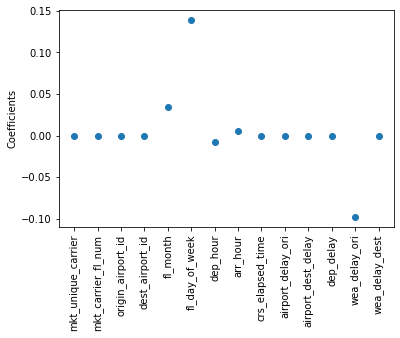

In [379]:
# Using lasso to extract important features  (fly_month, day of the week, arr_hour are important features)
lasso_coef=lasso.fit(X_train,y_train).coef_
names=DF.columns
_=plt.scatter(range(len(names)), lasso_coef)
_=plt.xticks(range(len(names)), names, rotation=90)
_=plt.ylabel('Coefficients')
plt.show()

In [367]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.3, random_state=0)
ridge=Ridge(alpha=0.01)
ridge.fit(X_train, y_train)
y_ridge=ridge.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test,y_ridge))) 


28.887868372522803


In [387]:
import xgboost as xg
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 10, seed = 123) 
  
# Fitting the model 
xgb_r.fit(X_train, y_train) 
  
# Predict the model 
pred = xgb_r.predict(X_test) 
  
# RMSE Computation 
rmse = metrics.mean_squared_error(y_test,pred, squared=False) 
print("RMSE : % f" %(rmse)) 

RMSE :  28.843577


In [388]:
xgb_r.score(X_train,y_train)

0.011704841957072665

In [390]:
scores = cross_val_score(xgb_r, X_train, y_train, cv=5)
print("Mean cross-validation score:",  scores.mean())

Mean cross-validation score: 0.0034712009447293466
